In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import random

### utils

In [2]:
def rk_ode_int(f, x0, y0, h, a, b, c):   
    k = list()
    for i in range(a.shape[0]):
        k.append(
            f(x0 + c[i] * h, y0 + h * sum(a[i, j] * k[j] for j in range(i)))
        )
    y1 = y0 + h * sum(b[i] * k[i] for i in range(a.shape[0]))
    
    return y1

def get_poisson_randint_between(low_bound, high_bound, a):
    while True:
        num = poisson(a).rvs()
        if low_bound <= num <= high_bound:
            return num

# Modeling of Poisson point process for populations

We will consider next system of ordinary differential equations:
$$ 
\begin{cases}
\frac{d P_0(t)}{d t} = \mu_{1} P_1(t) - (\lambda_0 + y_{\lambda_0}(t)) P_0(t) \\
\vdots \\
\frac{d P_i(t)}{d t} = \mu_{i+1} P_{i+1}(t) +  (\lambda_{i-1} + y_{\lambda_{i-1}}(t)) P_{i-1}(t) 
    - (\lambda_{i} + y_{\lambda_{i}}(t) + \mu_{i})  P_{i}(t) \\
\vdots \\
\frac{d P_n(t)}{d t} = (\lambda_{n-1} + y_{\lambda_{n-1}}(t)) P_{n-1}(t) - \mu_n  P_{n}(t)
\end{cases}
$$
where:
* $ P_i(t) $ - probability of number of population equivalent to i
* $ \lambda_i $ - linear apploximation of transient probabilities for population increase in small time step
*     $ \mu_i $ - linear apploximation of transient probabilities for population decrease in small time step
* $ y_{\lambda_{i}}(t) $ - external conditions, that influence on population increase.
  
  
The task is to find and plot solution

## 1. Model initialization

### Parameters definitions

In [3]:
n = 21
interval = (0, 80)

lambd = [0, ] + [2 + 0.01*i for i in range(1, n-1)] + [0, ]
mu = [0, ] + [0.3 + 0.05*i for i in range(1, n-1)] + [0.4, ]

y = [lambda t: 0, ] + [lambda t: np.sin(t) for _ in range(1, n-1)] + [lambda t: 0, ]
# y = [lambda t: 0 for _ in range(n)]

## 2. Finding numerical solution
Using Runge-Kutta numerical method

In [4]:
p_beg = np.matrix([poisson(4).pmf(range(n)), ]).T

### Building of Kolmogorov forward equations

In [5]:
def F(t, p):
    vector_components = list()
    
    vector_components.append(mu[1] * p[1, 0] - (lambd[0] + y[0](t)) * p[0, 0])
    
    for i in range(1, p.shape[0] - 1):
        vector_components.append(
            mu[i+1] * p[i+1, 0] 
            + (lambd[i-1] + y[i-1](t)) * p[i-1, 0] 
            - (lambd[i] + y[i](t) + mu[i]) * p[i, 0]
        )
        
    vector_components.append((lambd[-2] + y[-2](t)) * p[-2, 0] - mu[-1] * p[-1, 0])
    
    return np.matrix([vector_components, ]).T

### Defining parameters of numerical solution

In [6]:
h = 10e-3

a = np.matrix([
    [  0, 0],
    [1/2, 0]
])
b = [0, 1]
c = [0, ] + [sum(a[i, j] for j in range(i)) for i in range(1, a.shape[0])]

### Solving

In [7]:
numerical_t = np.arange(*interval, h)
numerical_p = [p_beg, ]

for t_i in numerical_t[:-1]:
    p_i = numerical_p[-1]
    numerical_p.append(rk_ode_int(F, t_i, p_i, h, a, b, c))
    
# Now numerical_p is list of solutions in different time moments
# Lets convert it to list of values it time moments of each solution component

numerical_p = [p_i.T.tolist()[0] for p_i in numerical_p]
numerical_p = list(zip(*numerical_p))

## 3. Finding simulation solution

### Building experiment scheme

In [8]:
def trial(beg_population_num, t):
    steps = (next_t - prev_t for next_t, prev_t in zip(t[1:], t[:-1]))
    
    population_num = [beg_population_num, ]
    for h, t_i in zip(steps, t[1:]):
        prob_increase = (lambd[population_num[-1]] + y[population_num[-1]](t_i)) * h
        prob_decrease = mu[population_num[-1]] * h
        prob_constancy = 1 - prob_increase - prob_decrease
        
        population_num_shift = random.choices(
            [-1, 0, 1], weights=[prob_decrease, prob_constancy, prob_increase]
        )[0]
        
        population_num.append(population_num[-1] + population_num_shift)
    
    return population_num

### Defining parameters of simulation solution

In [9]:
h = 10e-2
trials_num = 1000

### Solving

In [10]:
simulation_t = np.arange(*interval, h)

randint = lambda : get_poisson_randint_between(0, n, 4)
results = [trial(randint(), simulation_t) for _ in range(trials_num)]

simulation_p = [[p_in_t.count(i)/trials_num for p_in_t in zip(*results)] for i in range(n)]

## 4. Plot solutions

### Graphs of numerical solution

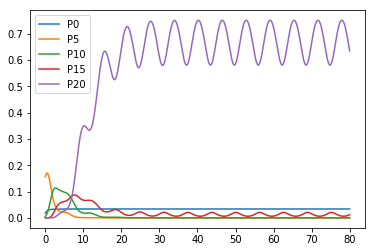

In [11]:
for i in range(0, n, n//4):
    plt.plot(numerical_t, numerical_p[i], label=f'P{i}')
    
plt.legend()
plt.show()

### Graphs of simulation solution

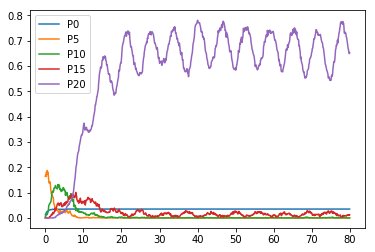

In [12]:
for i in range(0, n, n//4):
    plt.plot(simulation_t, simulation_p[i], label=f'P{i}')
    
plt.legend()
plt.show()

---